In [0]:
import numpy as np
import sys
sys.path.append('/content/drive/My Drive/UoB physics/year 4/FYP')
from neuralStellar2 import stellarGrid,NNmodel
from datetime import datetime
from matplotlib import rc
rc("font", family="serif", size=14)
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l1, l2
import pickle
from google.colab import output

Using TensorFlow backend.


In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def set_seed(self, seed):
    ''' Set the seed '''
    np.random.seed(seed)
    tf.random.set_random_seed(seed)
NNmodel.set_seed = set_seed

In [0]:
grid_file = 'drive/My Drive/UoB physics/year 4/FYP/grid2_trun_RGB.csv'
all_df = pd.read_csv(grid_file)

In [0]:
solar_df = all_df[all_df['initial_MLT']==1.9]
solar_df = solar_df[solar_df['initial_Yinit']==0.28]
solar_df = solar_df[solar_df['initial_feh']==0.0]
grid1 = stellarGrid(solar_df)
grid1.popIndex(['Unnamed: 0','star_mass','star_age','star_feh','initial_Yinit','initial_MLT','luminosity','radius','effective_T','delta_nu'])
grid1.initialData()
#df = grid1.data[grid1.data['track_no'].isin([0,2,4,6,8,10,12,14,16,18,20])]
df = grid1.data
grid1.data = df
df = df.sample(frac=1.0).reset_index(drop=True)

Data headers = 
Index(['step', 'evol_stage', 'initial_mass', 'Y', 'initial_feh', 'MLT', 'mass',
       'age', 'Teff', 'L', 'radius', 'feh', 'delnu', 'nu_max', 'tenfeh',
       'tenstarfeh'],
      dtype='object')


25517


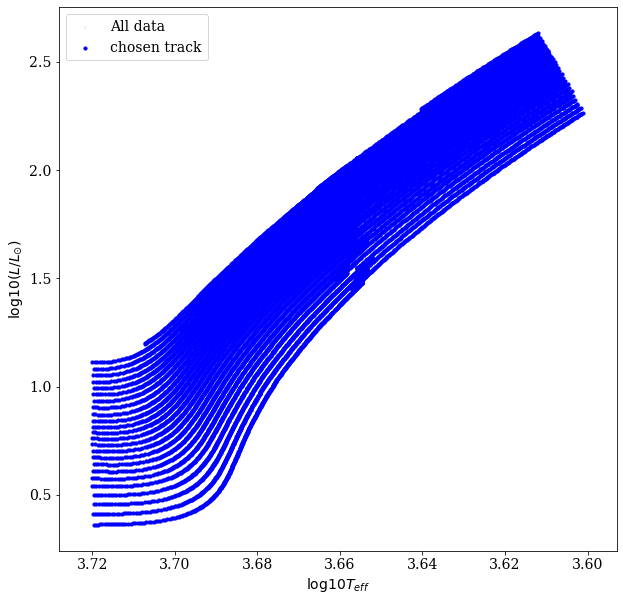

In [0]:
#df['tenfeh'] = 10**df.star_feh
df['scale_T'] = (df.Teff/5000)
x_cols = ['mass', 'age', 'tenstarfeh', 'Y', 'MLT']
y_cols = ['radius', 'scale_T', 'delnu']
N = len(df.index)
print(N)
points = solar_df
fig, ax=plt.subplots(1,1,figsize=[10,10])
ax.scatter(np.log10(points['effective_T']),np.log10(points['luminosity']),s=5,zorder=1,c='lightgrey',alpha=0.2,label='All data')
ax.scatter(np.log10(df['Teff']),np.log10(df['L']),s=10,zorder=2,c='blue',label='chosen track')
ax.set_xlim(ax.get_xlim()[::-1])
ax.set_xlabel(r'$\log10 T_{eff}$')
ax.set_ylabel(r'$\log10(L/L_{\odot})$')
ax.legend()
plt.show()

In [0]:
config = tf.ConfigProto(device_count = {'GPU': 0})
sess = tf.Session(config=config)
config.gpu_options.allow_growth = True

In [0]:
arch = [len(x_cols), 60,60,60,60,60,60,60, len(y_cols)]
m1=NNmodel('evo',['mass', 'age', 'feh', 'Y', 'MLT'], ['radius','Teff', 'delnu'], Teff_scaling=5000)
m1.history=m0.history.copy()
m1.buildModel(arch, 'elu')
m1.compileModel('Nadam', 1e-5, 'MAE', metrics=['MAE','MSE'], beta_1=0.9995, beta_2=0.999)
#m1.loadModel('drive/My Drive/UoB physics/year 4/FYP/track_test/023_best_model.h5')
m1.setWeights(m0.model)
#m1.loadHist('drive/My Drive/UoB physics/year 4/FYP/track_test/023trainHistoryDict', filetype='pickle')

Model: "neuralstellar"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 5)]               0         
_________________________________________________________________
dense_72 (Dense)             (None, 60)                360       
_________________________________________________________________
dense_73 (Dense)             (None, 60)                3660      
_________________________________________________________________
dense_74 (Dense)             (None, 60)                3660      
_________________________________________________________________
dense_75 (Dense)             (None, 60)                3660      
_________________________________________________________________
dense_76 (Dense)             (None, 60)                3660      
_________________________________________________________________
dense_77 (Dense)             (None, 60)              

In [67]:
#lr = [0.0001,0.0002,0.0005,0.001]
#batch_size = [1000,2000,5000,10000,20000,50000,100000,200000,500000,1000000]
#epoch_no = [200,200,450,450,750,750,750,750,1500,4500]
m1.fitModel(df, [x_cols,y_cols], 100000, int(N/1), 'drive/My Drive/UoB physics/year 4/FYP/track_test/023', callback=['mc'])
m1.saveHist('drive/My Drive/UoB physics/year 4/FYP/track_test/023trainHistoryDict')
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

training done! now=2020-02-29 16:16:06.429954 | Time elapsed=0:28:26.200509


0.0009445964


/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


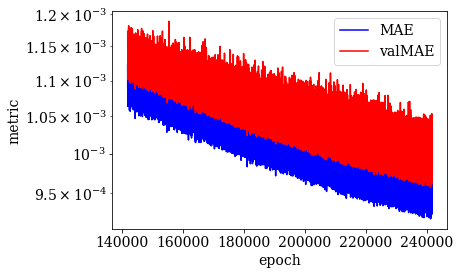

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


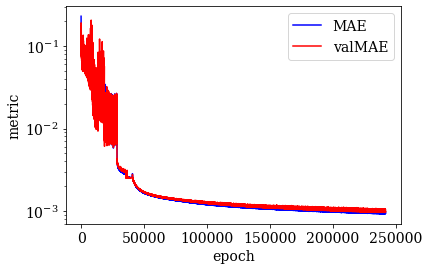

280427/280427 - 0s


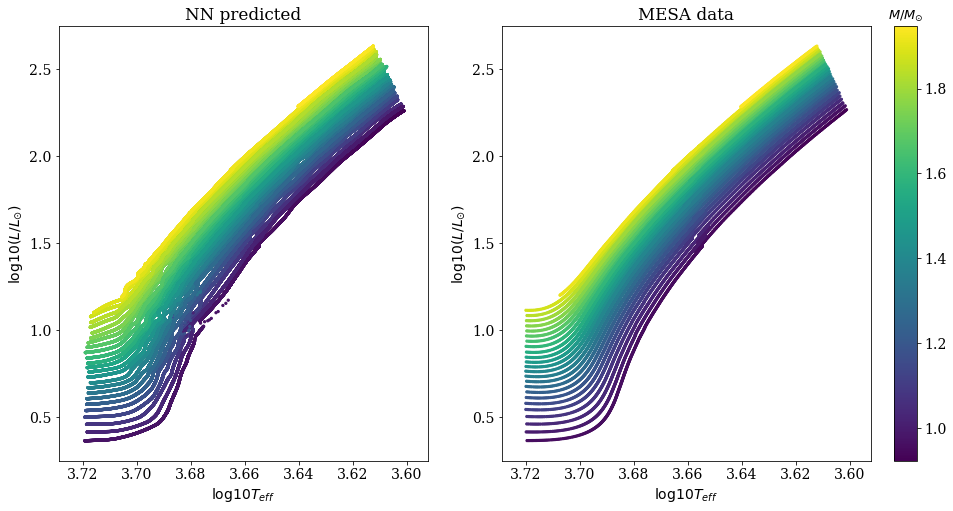

280427/280427 - 0s
25517/25517 - 0s


/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


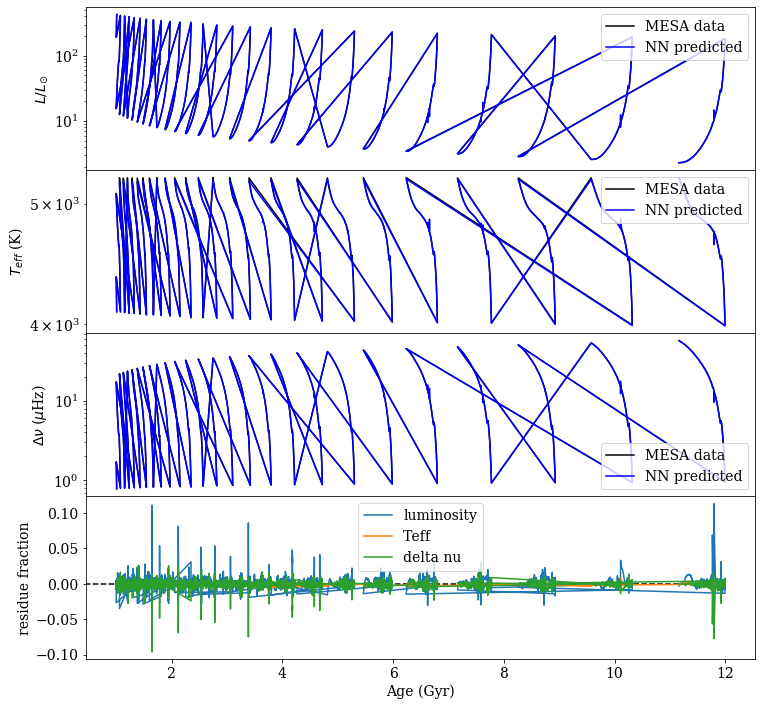

In [70]:
print(m1.lastLoss('mean_absolute_error'))
m1.plotHist(plot_MSE=False, epochs=[36000,'max'], this_train=True)
m1.plotHist(plot_MSE=False, epochs=[0,'max'])
m1.plotHR(grid1, in_between=10, track_no=50, match_axes=True)
m1.plotTrends(grid1, in_between=10, track_no=26)
#m1.plotIsochrone(grid1, np.linspace(1,11,12), ['age','feh','Y','MLT'], [0, 0.28,1.9],
#                 widths=[['r',0.05],['a',0.1],['a',0.01],['a',0.1]], one_per_track=True,extended=False)
#m1.plotIsochrone(grid1, np.linspace(1,11,12), ['age','feh','Y','MLT'], [0, 0.28,1.9],
#                 widths=[['r',0.05],['a',0.1],['a',0.01],['a',0.1]], one_per_track=False,extended=True)

In [0]:
m0=m1

In [0]:
m1=m0

In [0]:
m1.history['legs']

[{'batch_size': 12,
  'cumulative_epochs': 100,
  'decay': 0,
  'dropout': None,
  'epoch_no': 100,
  'epoch_range': [0, 99],
  'final_loss': 0.08885543,
  'leg_no': 1,
  'loss_func': 'MAE',
  'lr': 0.0001,
  'momentum': 'N/A',
  'optimizer': 'Nadam',
  'recompile': True,
  'reg': None,
  'runtime': datetime.timedelta(0, 804, 821459)},
 {'batch_size': 12,
  'cumulative_epochs': 200,
  'decay': 0,
  'dropout': None,
  'epoch_no': 100,
  'epoch_range': [99, 199],
  'final_loss': 0.06809921,
  'leg_no': 2,
  'loss_func': 'MAE',
  'lr': 0.0001,
  'momentum': 'N/A',
  'optimizer': 'Nadam',
  'recompile': False,
  'reg': None,
  'runtime': datetime.timedelta(0, 760, 804229)},
 {'batch_size': 12,
  'cumulative_epochs': 300,
  'decay': 0,
  'dropout': None,
  'epoch_no': 100,
  'epoch_range': [199, 299],
  'final_loss': 0.0639308,
  'leg_no': 3,
  'loss_func': 'MAE',
  'lr': 0.0001,
  'momentum': 'N/A',
  'optimizer': 'Nadam',
  'recompile': False,
  'reg': None,
  'runtime': datetime.timedelt

found 27793 stars.
30000/30000 - 0s


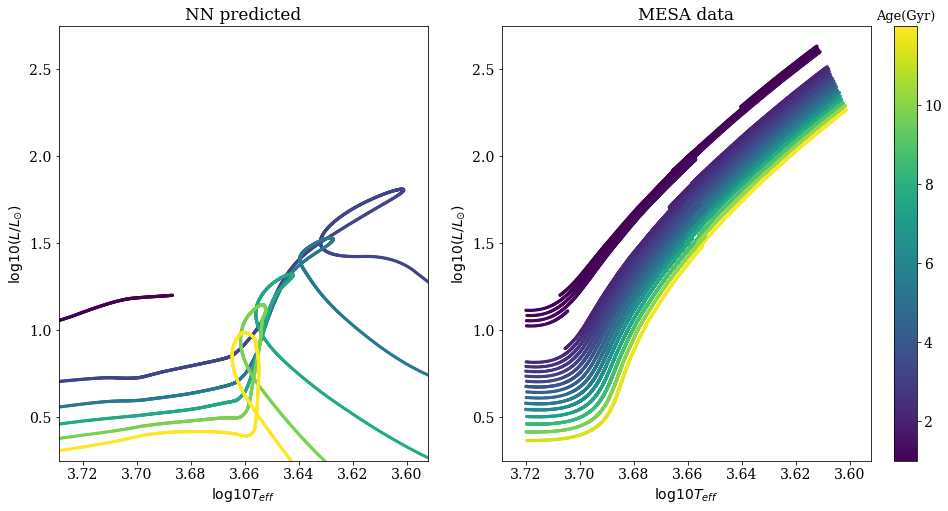

In [0]:
m1.plotIsochrone(grid1, [1,3,5,7,9,11], ['age','feh','Y','MLT'], [0, 0.28,1.9],
                 widths=[['r',0.3],['a',0.3],['a',0.01],['a',0.1]], one_per_track=False)

In [0]:
print(m1.runtime())

2:31:20.985576
